# Second round of small ring experiments

In [1]:
from qcportal.client import FractalClient
# from qcfractal import FractalSnowflakeHandler
from openff.toolkit import Molecule
qcarchive_client = FractalClient()

from openff.qcsubmit.results.filters import ConnectivityFilter,HydrogenBondFilter
from openff.toolkit import ForceField
from openff.qcsubmit.results import TorsionDriveResultCollection, OptimizationResultCollection
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import minimize
import copy
# suppress stereochemistry warnings
import logging
logging.getLogger("openff").setLevel(logging.ERROR)

from openff.units import unit

from openff.interchange import Interchange
from openff.interchange.drivers import get_openmm_energies

import typing
from collections import defaultdict, Counter
import functools
import multiprocessing
import tqdm
from openff.qcsubmit.results.filters import SMARTSFilter
from openff.toolkit.typing.engines.smirnoff import AngleHandler

In [4]:
from openff.toolkit.topology import FrozenMolecule
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import Descriptors
from rdkit.Chem.rdDepictor import Compute2DCoords
from IPython.display import SVG

DEFAULT_WIDTH = 980
DEFAULT_HEIGHT = 400
def draw_molecule(
    molecule,
    image_width = DEFAULT_WIDTH,
    image_height= DEFAULT_HEIGHT,
    highlight_atoms= None,
    highlight_bonds = None,
    atom_notes = None,
    bond_notes = None,
    explicit_hydrogens = None,
    color_by_element = None,
):
    """Draw a molecule
    Parameters
    ==========
    molecule
        The molecule to draw.
    image_width
        The width of the resulting image in pixels.
    image_height
        The height of the resulting image in pixels.
    highlight_atoms
        A list of atom indices to highlight, or a map from indices to colors.
        Colors should be given as triplets of floats between 0.0 and 1.0.
    highlight_atoms
        A list of pairs of atom indices indicating bonds to highlight, or a map
        from index pairs to colors. Colors should be given as triplets of floats
        between 0.0 and 1.0.
    atom_notes
        A map from atom indices to a string that should be printed near the
        atom.
    bond_notes
        A map from atom index pairs to a string that should be printed near the
        bond.
    explicit_hydrogens
        If ``False``, allow uncharged monovalent hydrogens to be hidden. If
        ``True``, make all hydrogens explicit. If ``None``
    color_by_element
        If True, color heteroatoms according to their element; if False, the
        image will be black and white. By default, uses black and white when
        highlight_atoms or highlight_bonds is provided, and color otherwise.
    Raises
    ======
    KeyError
        When an atom or bond in highlight_atoms or highlight_bonds is missing
        from the image, including when it is present in the molecule but hidden.
    """
    if isinstance(molecule, FrozenMolecule):
        rdmol = molecule.to_rdkit()
    else:
        rdmol = molecule

    if color_by_element is None:
        color_by_element = highlight_atoms is None and highlight_bonds is None

    if explicit_hydrogens is None:
        idx_map = {i: i for i in range(rdmol.GetNumAtoms())}
    elif explicit_hydrogens:
        idx_map = {i: i for i in range(rdmol.GetNumAtoms())}
        rdmol = Chem.AddHs(rdmol, explicitOnly=True)
    else:
        idx_map = {
            old: new
            for new, old in enumerate(
                a.GetIdx()
                for a in rdmol.GetAtoms()
                if a.GetAtomicNum() != 1 and a.GetMass() != 1
            )
        }
        rdmol = Chem.RemoveHs(rdmol, updateExplicitCount=True)

    if highlight_atoms is None:
        highlight_atoms = []
        highlight_atom_colors = None
    elif isinstance(highlight_atoms, dict):
        highlight_atom_colors = {
            idx_map[i]: tuple(c) for i, c in highlight_atoms.items() if i in idx_map
        }
        highlight_atoms = list(highlight_atoms.keys())
    else:
        highlight_atoms = [idx_map[i] for i in highlight_atoms if i in idx_map]
        highlight_atom_colors = None

    if highlight_bonds is None:
        highlight_bonds = []
        highlight_bond_colors = None
    elif isinstance(highlight_bonds, dict):
        highlight_bond_colors = {
            rdmol.GetBondBetweenAtoms(idx_map[i_a], idx_map[i_b]).GetIdx(): tuple(v)
            for (i_a, i_b), v in highlight_bonds.items()
            if i_a in idx_map and i_b in idx_map
        }

        highlight_bonds = list(highlight_bond_colors.keys())
    else:
        highlight_bonds = [
            rdmol.GetBondBetweenAtoms(idx_map[i_a], idx_map[i_b])
            for i_a, i_b in highlight_bonds
            if i_a in idx_map and i_b in idx_map
        ]
        highlight_bond_colors = None

    if bond_notes is not None:
        for (i_a, i_b), note in bond_notes.items():
            if i_a not in idx_map or i_b not in idx_map:
                continue
            rdbond = rdmol.GetBondBetweenAtoms(idx_map[i_a], idx_map[i_b])
            rdbond.SetProp("bondNote", note)

    if atom_notes is not None:
        for i, note in atom_notes.items():
            if i not in idx_map:
                continue
            rdatom = rdmol.GetAtomWithIdx(idx_map[i])
            rdatom.SetProp("atomNote", note)

    Compute2DCoords(rdmol)

    drawer = Draw.MolDraw2DCairo(image_width, image_height)

    draw_options = drawer.drawOptions()
    if not color_by_element:
        draw_options.useBWAtomPalette()

    drawer.DrawMolecule(
        rdmol,
        highlightAtoms=highlight_atoms,
        highlightAtomColors=highlight_atom_colors,
        highlightBonds=highlight_bonds,
        highlightBondColors=highlight_bond_colors,
    )
    drawer.FinishDrawing()

    svg_contents = drawer.GetDrawingText()

    return svg_contents

def draw_molecule_svg(
    molecule,
    image_width = DEFAULT_WIDTH,
    image_height= DEFAULT_HEIGHT,
    highlight_atoms= None,
    highlight_bonds = None,
    atom_notes = None,
    bond_notes = None,
    explicit_hydrogens = None,
    color_by_element = None,
):
    """Draw a molecule
    Parameters
    ==========
    molecule
        The molecule to draw.
    image_width
        The width of the resulting image in pixels.
    image_height
        The height of the resulting image in pixels.
    highlight_atoms
        A list of atom indices to highlight, or a map from indices to colors.
        Colors should be given as triplets of floats between 0.0 and 1.0.
    highlight_atoms
        A list of pairs of atom indices indicating bonds to highlight, or a map
        from index pairs to colors. Colors should be given as triplets of floats
        between 0.0 and 1.0.
    atom_notes
        A map from atom indices to a string that should be printed near the
        atom.
    bond_notes
        A map from atom index pairs to a string that should be printed near the
        bond.
    explicit_hydrogens
        If ``False``, allow uncharged monovalent hydrogens to be hidden. If
        ``True``, make all hydrogens explicit. If ``None``
    color_by_element
        If True, color heteroatoms according to their element; if False, the
        image will be black and white. By default, uses black and white when
        highlight_atoms or highlight_bonds is provided, and color otherwise.
    Raises
    ======
    KeyError
        When an atom or bond in highlight_atoms or highlight_bonds is missing
        from the image, including when it is present in the molecule but hidden.
    """
    if isinstance(molecule, FrozenMolecule):
        rdmol = molecule.to_rdkit()
    else:
        rdmol = molecule

    if color_by_element is None:
        color_by_element = highlight_atoms is None and highlight_bonds is None

    if explicit_hydrogens is None:
        idx_map = {i: i for i in range(rdmol.GetNumAtoms())}
    elif explicit_hydrogens:
        idx_map = {i: i for i in range(rdmol.GetNumAtoms())}
        rdmol = Chem.AddHs(rdmol, explicitOnly=True)
    else:
        idx_map = {
            old: new
            for new, old in enumerate(
                a.GetIdx()
                for a in rdmol.GetAtoms()
                if a.GetAtomicNum() != 1 and a.GetMass() != 1
            )
        }
        rdmol = Chem.RemoveHs(rdmol, updateExplicitCount=True)

    if highlight_atoms is None:
        highlight_atoms = []
        highlight_atom_colors = None
    elif isinstance(highlight_atoms, dict):
        highlight_atom_colors = {
            idx_map[i]: tuple(c) for i, c in highlight_atoms.items() if i in idx_map
        }
        highlight_atoms = list(highlight_atoms.keys())
    else:
        highlight_atoms = [idx_map[i] for i in highlight_atoms if i in idx_map]
        highlight_atom_colors = None

    if highlight_bonds is None:
        highlight_bonds = []
        highlight_bond_colors = None
    elif isinstance(highlight_bonds, dict):
        highlight_bond_colors = {
            rdmol.GetBondBetweenAtoms(idx_map[i_a], idx_map[i_b]).GetIdx(): tuple(v)
            for (i_a, i_b), v in highlight_bonds.items()
            if i_a in idx_map and i_b in idx_map
        }

        highlight_bonds = list(highlight_bond_colors.keys())
    else:
        highlight_bonds = [
            rdmol.GetBondBetweenAtoms(idx_map[i_a], idx_map[i_b])
            for i_a, i_b in highlight_bonds
            if i_a in idx_map and i_b in idx_map
        ]
        highlight_bond_colors = None

    if bond_notes is not None:
        for (i_a, i_b), note in bond_notes.items():
            if i_a not in idx_map or i_b not in idx_map:
                continue
            rdbond = rdmol.GetBondBetweenAtoms(idx_map[i_a], idx_map[i_b])
            rdbond.SetProp("bondNote", note)

    if atom_notes is not None:
        for i, note in atom_notes.items():
            if i not in idx_map:
                continue
            rdatom = rdmol.GetAtomWithIdx(idx_map[i])
            rdatom.SetProp("atomNote", note)

    Compute2DCoords(rdmol)

    drawer = Draw.MolDraw2DSVG(image_width, image_height)

    draw_options = drawer.drawOptions()
    if not color_by_element:
        draw_options.useBWAtomPalette()

    drawer.DrawMolecule(
        rdmol,
        highlightAtoms=highlight_atoms,
        highlightAtomColors=highlight_atom_colors,
        highlightBonds=highlight_bonds,
        highlightBondColors=highlight_bond_colors,
    )
    drawer.FinishDrawing()

    svg_contents = drawer.GetDrawingText()

    return svg_contents



# Testing on fused rings
New pattern doesn't pick up fused exocyclic angles, but misses the internal angles for the larger ring for fused rings of different sizes.

In [8]:
sage_mod_1 = ForceField('output/initial-force-field.offxml')

In [26]:
def get_forces(topo):
    atoms = [i.atomic_number for i in topo.atoms]
    print(atoms)
    molecule_force_list = sage_mod_1.label_molecules(topo)

    # Print out a formatted description of the parameters applied to this molecule
    for mol_idx, mol_forces in enumerate(molecule_force_list):
        print(f"Forces for molecule {mol_idx}")
        for force_tag, force_dict in mol_forces.items():
            if force_tag == 'Angles':
                print(f"\n{force_tag}:")
                for atom_indices, parameter in force_dict.items():
                    if np.all(np.array([atoms[i] for i in atom_indices])!= 1) : 
                        atomstr = ""
                        for idx in atom_indices:
                            atomstr += "%3s" % idx
                        print(
                            f"atoms: {atomstr}  parameter_id: {parameter.id}  smirks {parameter.smirks}"
                        )

In [17]:
r3r3_fuse = Molecule.from_smiles('C13CC3C1',allow_undefined_stereo=True)
r3r3_spiro = Molecule.from_smiles('C13(CC3)CC1',allow_undefined_stereo=True)

In [19]:
r4r4_fuse = Molecule.from_smiles('C13CCC3CC1',allow_undefined_stereo=True)
r4r4_spiro = Molecule.from_smiles('C13(CCC3)CCC1',allow_undefined_stereo=True)

In [38]:
r3r4_fuse = Molecule.from_smiles('C13CCC3C1',allow_undefined_stereo=True)
r3r4_spiro = Molecule.from_smiles('C13(CCC3)CC1',allow_undefined_stereo=True)

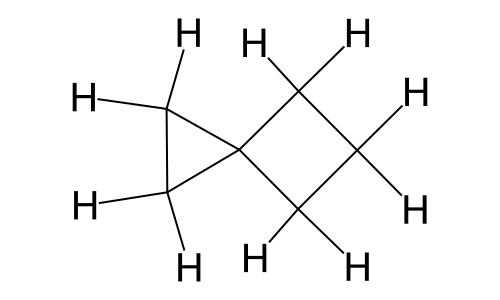

In [40]:
r3r4_spiro

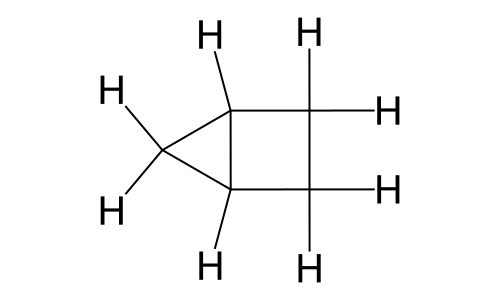

In [39]:
r3r4_fuse

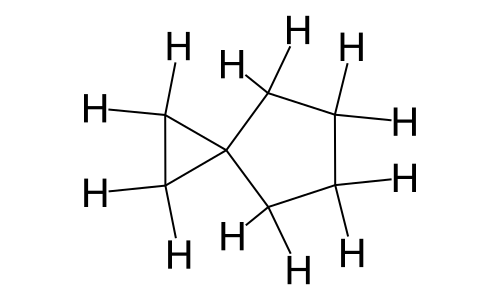

In [20]:
# r3r5fuse_mol = r5_problem_fuses_rm[0][1]
r3r5_spiro = Molecule.from_smiles('C1C2(CC2)CCC1')
r3r5_spiro

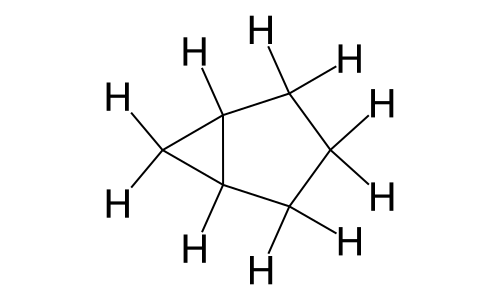

In [21]:
r3r5_fuse = Molecule.from_smiles('C1C2CC2CC1',allow_undefined_stereo=True)
r3r5_fuse

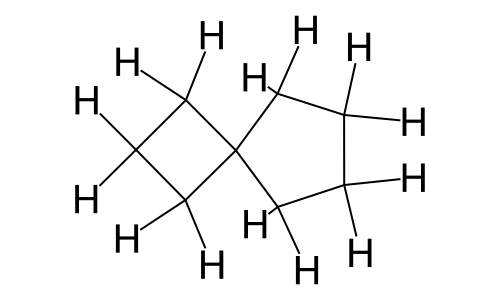

In [22]:
# r4r5spiro_mol = r5_problem_fuses_rm[5][1]
r4r5_spiro = Molecule.from_smiles('C13(CCC3)CCCC1')
r4r5_spiro

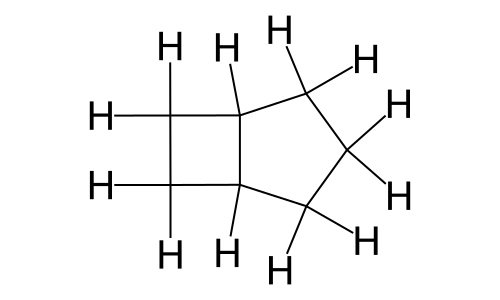

In [23]:
r4r5_fuse = Molecule.from_smiles('C13CCC3CCC1',allow_undefined_stereo=True)
r4r5_fuse

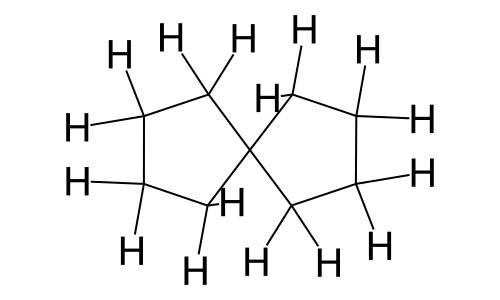

In [24]:
# r5r5spiro_mol = r5_problem_fuses_rm[16][1]
r5r5_spiro = Molecule.from_smiles('C13(CCCC3)CCCC1')
r5r5_spiro

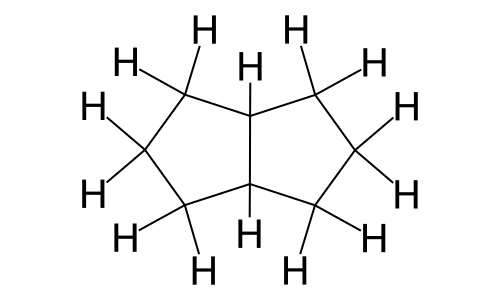

In [25]:
# r5r5fuse_mol =r5_problem_fuses_rm[12][1]
r5r5_fuse = Molecule.from_smiles('C13CCCC3CCC1',allow_undefined_stereo=True)
r5r5_fuse

[6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Forces for molecule 0

Angles:
atoms:   0  1  2  parameter_id: a7  smirks [*;r4:1]1-;@[*;r4:2]-;@[*;r4:3]-;@[*;r4]1
atoms:   0  3  2  parameter_id: a7  smirks [*;r4:1]1-;@[*;r4:2]-;@[*;r4:3]-;@[*;r4]1
atoms:   0  4  5  parameter_id: a7  smirks [*;r4:1]1-;@[*;r4:2]-;@[*;r4:3]-;@[*;r4]1
atoms:   0  6  5  parameter_id: a7  smirks [*;r4:1]1-;@[*;r4:2]-;@[*;r4:3]-;@[*;r4]1
atoms:   1  0  3  parameter_id: a7  smirks [*;r4:1]1-;@[*;r4:2]-;@[*;r4:3]-;@[*;r4]1
atoms:   1  0  4  parameter_id: a1  smirks [*:1]~[#6X4:2]-[*:3]
atoms:   1  0  6  parameter_id: a1  smirks [*:1]~[#6X4:2]-[*:3]
atoms:   1  2  3  parameter_id: a7  smirks [*;r4:1]1-;@[*;r4:2]-;@[*;r4:3]-;@[*;r4]1
atoms:   3  0  4  parameter_id: a1  smirks [*:1]~[#6X4:2]-[*:3]
atoms:   3  0  6  parameter_id: a1  smirks [*:1]~[#6X4:2]-[*:3]
atoms:   4  0  6  parameter_id: a7  smirks [*;r4:1]1-;@[*;r4:2]-;@[*;r4:3]-;@[*;r4]1
atoms:   4  5  6  parameter_id: a7  smirks [*;r4:1]1-;@[*;r4

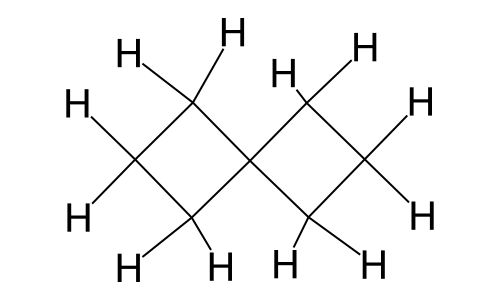

In [27]:
topo = r4r4_spiro.to_topology()
get_forces(topo)

r4r4_spiro

[6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Forces for molecule 0

Angles:
atoms:   0  1  2  parameter_id: a7  smirks [*;r4:1]1-;@[*;r4:2]-;@[*;r4:3]-;@[*;r4]1
atoms:   0  3  2  parameter_id: a7  smirks [*;r4:1]1-;@[*;r4:2]-;@[*;r4:3]-;@[*;r4]1
atoms:   0  3  4  parameter_id: a7  smirks [*;r4:1]1-;@[*;r4:2]-;@[*;r4:3]-;@[*;r4]1
atoms:   0  5  4  parameter_id: a7  smirks [*;r4:1]1-;@[*;r4:2]-;@[*;r4:3]-;@[*;r4]1
atoms:   1  0  3  parameter_id: a7  smirks [*;r4:1]1-;@[*;r4:2]-;@[*;r4:3]-;@[*;r4]1
atoms:   1  0  5  parameter_id: a1  smirks [*:1]~[#6X4:2]-[*:3]
atoms:   1  2  3  parameter_id: a7  smirks [*;r4:1]1-;@[*;r4:2]-;@[*;r4:3]-;@[*;r4]1
atoms:   2  3  4  parameter_id: a1  smirks [*:1]~[#6X4:2]-[*:3]
atoms:   3  0  5  parameter_id: a7  smirks [*;r4:1]1-;@[*;r4:2]-;@[*;r4:3]-;@[*;r4]1
atoms:   3  4  5  parameter_id: a7  smirks [*;r4:1]1-;@[*;r4:2]-;@[*;r4:3]-;@[*;r4]1


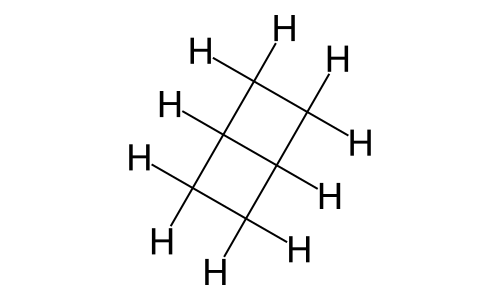

In [28]:
topo = r4r4_fuse.to_topology()
get_forces(topo)

r4r4_fuse

[6, 6, 6, 6, 1, 1, 1, 1, 1, 1]
Forces for molecule 0

Angles:
atoms:   0  1  2  parameter_id: a3  smirks [*;r3:1]1~;@[*;r3:2]~;@[*;r3:3]1
atoms:   0  2  1  parameter_id: a3  smirks [*;r3:1]1~;@[*;r3:2]~;@[*;r3:3]1
atoms:   0  2  3  parameter_id: a3  smirks [*;r3:1]1~;@[*;r3:2]~;@[*;r3:3]1
atoms:   0  3  2  parameter_id: a3  smirks [*;r3:1]1~;@[*;r3:2]~;@[*;r3:3]1
atoms:   1  0  2  parameter_id: a3  smirks [*;r3:1]1~;@[*;r3:2]~;@[*;r3:3]1
atoms:   1  0  3  parameter_id: a1  smirks [*:1]~[#6X4:2]-[*:3]
atoms:   1  2  3  parameter_id: a1  smirks [*:1]~[#6X4:2]-[*:3]
atoms:   2  0  3  parameter_id: a3  smirks [*;r3:1]1~;@[*;r3:2]~;@[*;r3:3]1


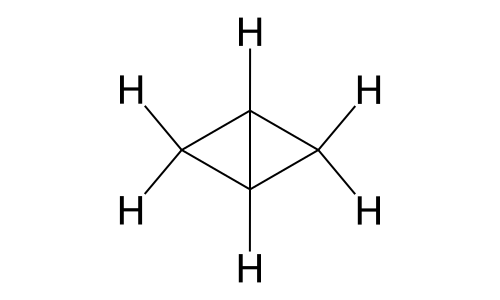

In [29]:
topo = r3r3_fuse.to_topology()
get_forces(topo)

r3r3_fuse

[6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1]
Forces for molecule 0

Angles:
atoms:   0  1  2  parameter_id: a3  smirks [*;r3:1]1~;@[*;r3:2]~;@[*;r3:3]1
atoms:   0  2  1  parameter_id: a3  smirks [*;r3:1]1~;@[*;r3:2]~;@[*;r3:3]1
atoms:   0  3  4  parameter_id: a3  smirks [*;r3:1]1~;@[*;r3:2]~;@[*;r3:3]1
atoms:   0  4  3  parameter_id: a3  smirks [*;r3:1]1~;@[*;r3:2]~;@[*;r3:3]1
atoms:   1  0  2  parameter_id: a3  smirks [*;r3:1]1~;@[*;r3:2]~;@[*;r3:3]1
atoms:   1  0  3  parameter_id: a1  smirks [*:1]~[#6X4:2]-[*:3]
atoms:   1  0  4  parameter_id: a1  smirks [*:1]~[#6X4:2]-[*:3]
atoms:   2  0  3  parameter_id: a1  smirks [*:1]~[#6X4:2]-[*:3]
atoms:   2  0  4  parameter_id: a1  smirks [*:1]~[#6X4:2]-[*:3]
atoms:   3  0  4  parameter_id: a3  smirks [*;r3:1]1~;@[*;r3:2]~;@[*;r3:3]1


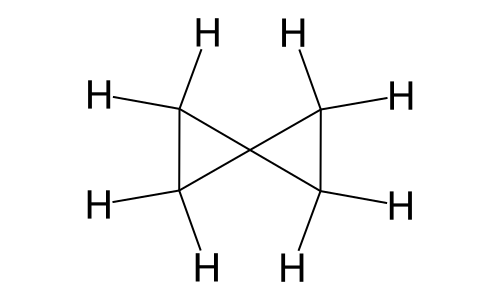

In [30]:
topo = r3r3_spiro.to_topology()
get_forces(topo)

r3r3_spiro

[6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Forces for molecule 0

Angles:
atoms:   0  1  2  parameter_id: a41  smirks [*;r5:1]@1[*;r5:2]@[*;r5:3]@[r5]@[r5]@1
atoms:   0  4  3  parameter_id: a41  smirks [*;r5:1]@1[*;r5:2]@[*;r5:3]@[r5]@[r5]@1
atoms:   0  5  6  parameter_id: a41  smirks [*;r5:1]@1[*;r5:2]@[*;r5:3]@[r5]@[r5]@1
atoms:   0  8  7  parameter_id: a41  smirks [*;r5:1]@1[*;r5:2]@[*;r5:3]@[r5]@[r5]@1
atoms:   1  0  4  parameter_id: a41  smirks [*;r5:1]@1[*;r5:2]@[*;r5:3]@[r5]@[r5]@1
atoms:   1  0  5  parameter_id: a1  smirks [*:1]~[#6X4:2]-[*:3]
atoms:   1  0  8  parameter_id: a1  smirks [*:1]~[#6X4:2]-[*:3]
atoms:   1  2  3  parameter_id: a41  smirks [*;r5:1]@1[*;r5:2]@[*;r5:3]@[r5]@[r5]@1
atoms:   2  3  4  parameter_id: a41  smirks [*;r5:1]@1[*;r5:2]@[*;r5:3]@[r5]@[r5]@1
atoms:   4  0  5  parameter_id: a1  smirks [*:1]~[#6X4:2]-[*:3]
atoms:   4  0  8  parameter_id: a1  smirks [*:1]~[#6X4:2]-[*:3]
atoms:   5  0  8  parameter_id: a41  smirks [*;r5

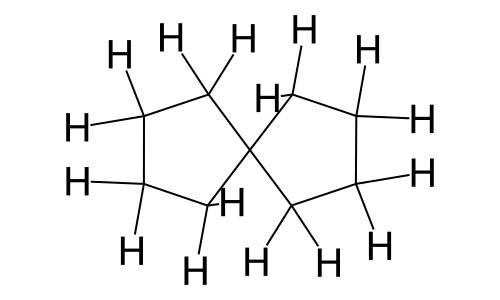

In [31]:
topo = r5r5_spiro.to_topology()
get_forces(topo)

r5r5_spiro

[6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Forces for molecule 0

Angles:
atoms:   0  1  2  parameter_id: a41  smirks [*;r5:1]@1[*;r5:2]@[*;r5:3]@[r5]@[r5]@1
atoms:   0  4  3  parameter_id: a41  smirks [*;r5:1]@1[*;r5:2]@[*;r5:3]@[r5]@[r5]@1
atoms:   0  4  5  parameter_id: a41  smirks [*;r5:1]@1[*;r5:2]@[*;r5:3]@[r5]@[r5]@1
atoms:   0  7  6  parameter_id: a41  smirks [*;r5:1]@1[*;r5:2]@[*;r5:3]@[r5]@[r5]@1
atoms:   1  0  4  parameter_id: a41  smirks [*;r5:1]@1[*;r5:2]@[*;r5:3]@[r5]@[r5]@1
atoms:   1  0  7  parameter_id: a1  smirks [*:1]~[#6X4:2]-[*:3]
atoms:   1  2  3  parameter_id: a41  smirks [*;r5:1]@1[*;r5:2]@[*;r5:3]@[r5]@[r5]@1
atoms:   2  3  4  parameter_id: a41  smirks [*;r5:1]@1[*;r5:2]@[*;r5:3]@[r5]@[r5]@1
atoms:   3  4  5  parameter_id: a1  smirks [*:1]~[#6X4:2]-[*:3]
atoms:   4  0  7  parameter_id: a41  smirks [*;r5:1]@1[*;r5:2]@[*;r5:3]@[r5]@[r5]@1
atoms:   4  5  6  parameter_id: a41  smirks [*;r5:1]@1[*;r5:2]@[*;r5:3]@[r5]@[r5]@1
atoms:   5  6  7  

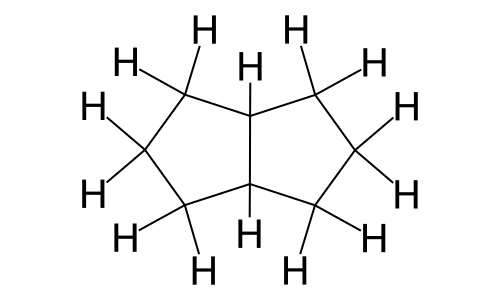

In [32]:
topo = r5r5_fuse.to_topology()
get_forces(topo)

r5r5_fuse

For same-same fuse/spiro, all internal angles are correct, while external angles are correctly assigned a1

[6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Forces for molecule 0

Angles:
atoms:   0  1  2  parameter_id: a1  smirks [*:1]~[#6X4:2]-[*:3]
atoms:   0  1  3  parameter_id: a1  smirks [*:1]~[#6X4:2]-[*:3]
atoms:   0  5  4  parameter_id: a1  smirks [*:1]~[#6X4:2]-[*:3]
atoms:   1  0  5  parameter_id: a1  smirks [*:1]~[#6X4:2]-[*:3]
atoms:   1  2  3  parameter_id: a3  smirks [*;r3:1]1~;@[*;r3:2]~;@[*;r3:3]1
atoms:   1  3  2  parameter_id: a3  smirks [*;r3:1]1~;@[*;r3:2]~;@[*;r3:3]1
atoms:   1  3  4  parameter_id: a1  smirks [*:1]~[#6X4:2]-[*:3]
atoms:   2  1  3  parameter_id: a3  smirks [*;r3:1]1~;@[*;r3:2]~;@[*;r3:3]1
atoms:   2  3  4  parameter_id: a1  smirks [*:1]~[#6X4:2]-[*:3]
atoms:   3  4  5  parameter_id: a1  smirks [*:1]~[#6X4:2]-[*:3]


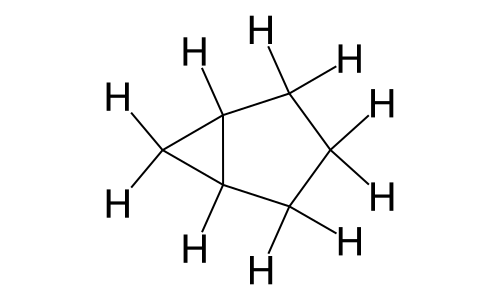

In [33]:
topo = r3r5_fuse.to_topology()
get_forces(topo)

r3r5_fuse

[6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Forces for molecule 0

Angles:
atoms:   0  1  2  parameter_id: a1  smirks [*:1]~[#6X4:2]-[*:3]
atoms:   0  1  3  parameter_id: a1  smirks [*:1]~[#6X4:2]-[*:3]
atoms:   0  1  4  parameter_id: a1  smirks [*:1]~[#6X4:2]-[*:3]
atoms:   0  6  5  parameter_id: a1  smirks [*:1]~[#6X4:2]-[*:3]
atoms:   1  0  6  parameter_id: a1  smirks [*:1]~[#6X4:2]-[*:3]
atoms:   1  2  3  parameter_id: a3  smirks [*;r3:1]1~;@[*;r3:2]~;@[*;r3:3]1
atoms:   1  3  2  parameter_id: a3  smirks [*;r3:1]1~;@[*;r3:2]~;@[*;r3:3]1
atoms:   1  4  5  parameter_id: a1  smirks [*:1]~[#6X4:2]-[*:3]
atoms:   2  1  3  parameter_id: a3  smirks [*;r3:1]1~;@[*;r3:2]~;@[*;r3:3]1
atoms:   2  1  4  parameter_id: a1  smirks [*:1]~[#6X4:2]-[*:3]
atoms:   3  1  4  parameter_id: a1  smirks [*:1]~[#6X4:2]-[*:3]
atoms:   4  5  6  parameter_id: a1  smirks [*:1]~[#6X4:2]-[*:3]


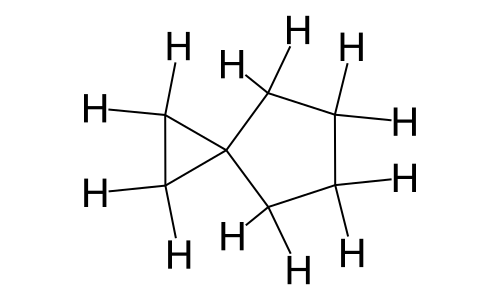

In [34]:
topo = r3r5_spiro.to_topology()
get_forces(topo)

r3r5_spiro

[6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Forces for molecule 0

Angles:
atoms:   0  1  2  parameter_id: a7  smirks [*;r4:1]1-;@[*;r4:2]-;@[*;r4:3]-;@[*;r4]1
atoms:   0  3  2  parameter_id: a7  smirks [*;r4:1]1-;@[*;r4:2]-;@[*;r4:3]-;@[*;r4]1
atoms:   0  3  4  parameter_id: a1  smirks [*:1]~[#6X4:2]-[*:3]
atoms:   0  6  5  parameter_id: a1  smirks [*:1]~[#6X4:2]-[*:3]
atoms:   1  0  3  parameter_id: a7  smirks [*;r4:1]1-;@[*;r4:2]-;@[*;r4:3]-;@[*;r4]1
atoms:   1  0  6  parameter_id: a1  smirks [*:1]~[#6X4:2]-[*:3]
atoms:   1  2  3  parameter_id: a7  smirks [*;r4:1]1-;@[*;r4:2]-;@[*;r4:3]-;@[*;r4]1
atoms:   2  3  4  parameter_id: a1  smirks [*:1]~[#6X4:2]-[*:3]
atoms:   3  0  6  parameter_id: a1  smirks [*:1]~[#6X4:2]-[*:3]
atoms:   3  4  5  parameter_id: a1  smirks [*:1]~[#6X4:2]-[*:3]
atoms:   4  5  6  parameter_id: a1  smirks [*:1]~[#6X4:2]-[*:3]


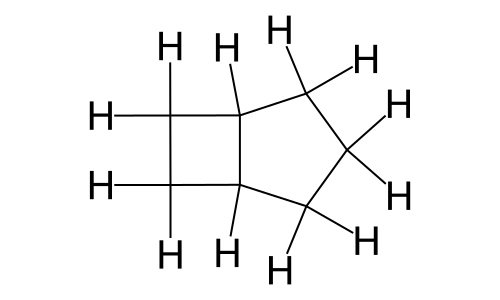

In [35]:
topo = r4r5_fuse.to_topology()
get_forces(topo)

r4r5_fuse

[6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Forces for molecule 0

Angles:
atoms:   0  1  2  parameter_id: a7  smirks [*;r4:1]1-;@[*;r4:2]-;@[*;r4:3]-;@[*;r4]1
atoms:   0  3  2  parameter_id: a7  smirks [*;r4:1]1-;@[*;r4:2]-;@[*;r4:3]-;@[*;r4]1
atoms:   0  4  5  parameter_id: a1  smirks [*:1]~[#6X4:2]-[*:3]
atoms:   0  7  6  parameter_id: a1  smirks [*:1]~[#6X4:2]-[*:3]
atoms:   1  0  3  parameter_id: a7  smirks [*;r4:1]1-;@[*;r4:2]-;@[*;r4:3]-;@[*;r4]1
atoms:   1  0  4  parameter_id: a1  smirks [*:1]~[#6X4:2]-[*:3]
atoms:   1  0  7  parameter_id: a1  smirks [*:1]~[#6X4:2]-[*:3]
atoms:   1  2  3  parameter_id: a7  smirks [*;r4:1]1-;@[*;r4:2]-;@[*;r4:3]-;@[*;r4]1
atoms:   3  0  4  parameter_id: a1  smirks [*:1]~[#6X4:2]-[*:3]
atoms:   3  0  7  parameter_id: a1  smirks [*:1]~[#6X4:2]-[*:3]
atoms:   4  0  7  parameter_id: a1  smirks [*:1]~[#6X4:2]-[*:3]
atoms:   4  5  6  parameter_id: a1  smirks [*:1]~[#6X4:2]-[*:3]
atoms:   5  6  7  parameter_id: a1  smirks [*:1]~[

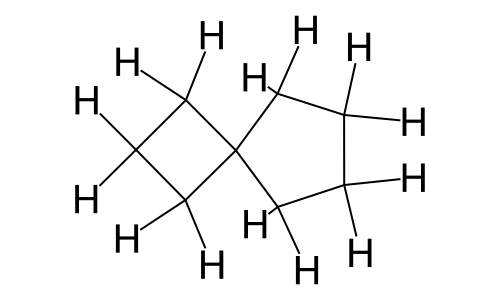

In [36]:
topo = r4r5_spiro.to_topology()
get_forces(topo)

r4r5_spiro

[6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Forces for molecule 0

Angles:
atoms:   0  1  2  parameter_id: a1  smirks [*:1]~[#6X4:2]-[*:3]
atoms:   0  3  2  parameter_id: a1  smirks [*:1]~[#6X4:2]-[*:3]
atoms:   0  4  5  parameter_id: a3  smirks [*;r3:1]1~;@[*;r3:2]~;@[*;r3:3]1
atoms:   0  5  4  parameter_id: a3  smirks [*;r3:1]1~;@[*;r3:2]~;@[*;r3:3]1
atoms:   1  0  3  parameter_id: a1  smirks [*:1]~[#6X4:2]-[*:3]
atoms:   1  0  4  parameter_id: a1  smirks [*:1]~[#6X4:2]-[*:3]
atoms:   1  0  5  parameter_id: a1  smirks [*:1]~[#6X4:2]-[*:3]
atoms:   1  2  3  parameter_id: a1  smirks [*:1]~[#6X4:2]-[*:3]
atoms:   3  0  4  parameter_id: a1  smirks [*:1]~[#6X4:2]-[*:3]
atoms:   3  0  5  parameter_id: a1  smirks [*:1]~[#6X4:2]-[*:3]
atoms:   4  0  5  parameter_id: a3  smirks [*;r3:1]1~;@[*;r3:2]~;@[*;r3:3]1


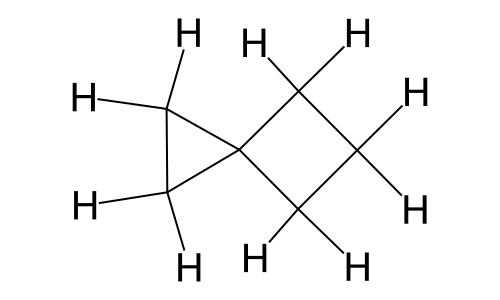

In [41]:
topo = r3r4_spiro.to_topology()
get_forces(topo)

r3r4_spiro

[6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1]
Forces for molecule 0

Angles:
atoms:   0  1  2  parameter_id: a1  smirks [*:1]~[#6X4:2]-[*:3]
atoms:   0  3  2  parameter_id: a1  smirks [*:1]~[#6X4:2]-[*:3]
atoms:   0  3  4  parameter_id: a3  smirks [*;r3:1]1~;@[*;r3:2]~;@[*;r3:3]1
atoms:   0  4  3  parameter_id: a3  smirks [*;r3:1]1~;@[*;r3:2]~;@[*;r3:3]1
atoms:   1  0  3  parameter_id: a1  smirks [*:1]~[#6X4:2]-[*:3]
atoms:   1  0  4  parameter_id: a1  smirks [*:1]~[#6X4:2]-[*:3]
atoms:   1  2  3  parameter_id: a1  smirks [*:1]~[#6X4:2]-[*:3]
atoms:   2  3  4  parameter_id: a1  smirks [*:1]~[#6X4:2]-[*:3]
atoms:   3  0  4  parameter_id: a3  smirks [*;r3:1]1~;@[*;r3:2]~;@[*;r3:3]1


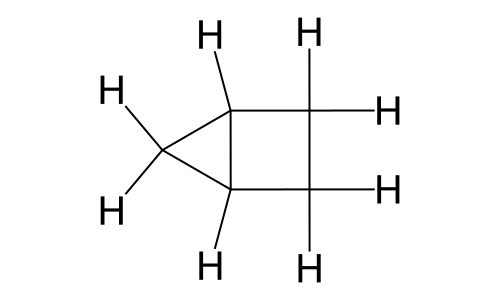

In [42]:
topo = r3r4_fuse.to_topology()
get_forces(topo)

r3r4_fuse

For two differently sized fused rings, only the smaller ring gets assigned the internal parameter. This is partially due to closing the internal ring parameters to prevent the same-same fuses from getting assigned the internal param...If we didn't close the rings, at least some of the larger ring would be assigned to its internal parameter, but it would pick up some external angles erroneously. Hard to say which is better